In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'viridis'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_13_ss6_np15/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
errors = compute_errors(data_path)#, force_sample=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [61]:
errors['weight>=0']['network_size'] = errors['weight>=0']['n_neurons'] * 2

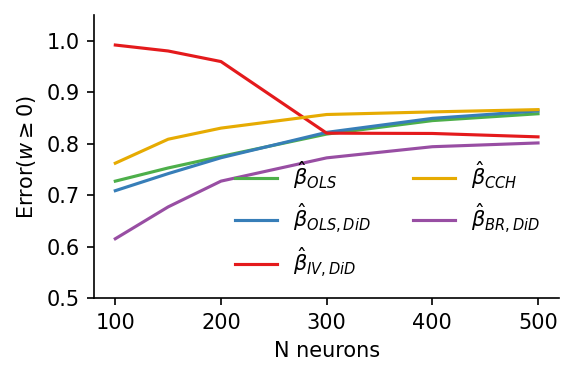

In [70]:
plot_errors(errors, 'network_size', 
            keys=['beta_ols', 
                  'beta_ols_did', 
                  'beta_iv_did', 
                  'naive_cch', 
                  'beta_brew_did'],
            legend_kws=dict(ncol=2),
            ylim=[0.5,1.05],
            xlabel='N neurons',
            save='sweep_13_error_n_neurons')

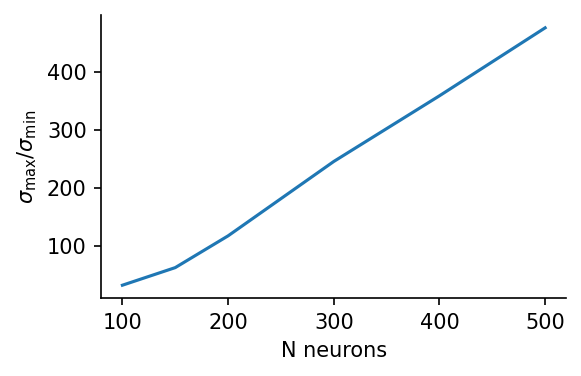

In [60]:
data_df['network_size'] = data_df['n_neurons'] * 2
plt.figure()
sns.lineplot(
    data=data_df,
    x="network_size", y='cov_condition'
)
plt.ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
plt.xlabel('N neurons')
# plt.ylim(0.5, 0.9)
# plt.margins(0.1)
sns.despine()
savefig(f'sweep_13_condition_n_neurons')

# Regression

In [8]:
samples = compute_all_samples(data_path)

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
index = int(errors[list(errors.keys())[0]].query('n_neurons==250').index.values)
index

2

In [27]:
df = samples[index]

In [32]:
dff = df.groupby('source').sample(1)

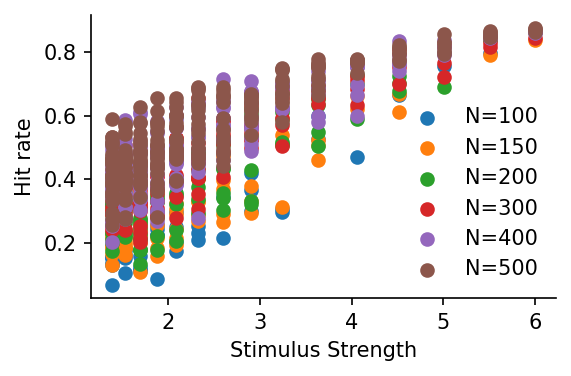

In [59]:
for i, (n_neurons, d) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    d = samples[int(d.index.values)].groupby('source').sample(1)
    plt.scatter(d.source_stim_strength, d.hit_rate, label=f'N={n_neurons*2:.0f}')
plt.legend(frameon=False)
plt.ylabel('Hit rate')
plt.xlabel('Stimulus Strength')
sns.despine()
savefig('sweep_13_hit_rate_stim_strength')

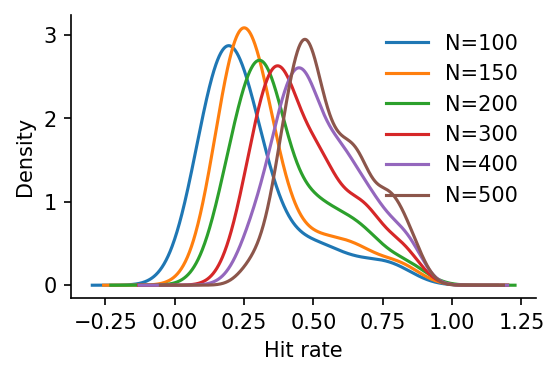

In [64]:
# fig, axs = plt.subplots(1,5, figsize=(5,2), sharey=True)
for i, (n_neurons, d) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    d = samples[int(d.index.values)].groupby('source').sample(1)
#     df.hit_rate.hist(ax=axs[i])
    d.hit_rate.plot.density(label=f'N={n_neurons*2:.0f}')
plt.legend(frameon=False)
sns.despine()
plt.xlabel('Hit rate')
savefig('sweep_13_hit_rate_distribution')

In [14]:
df.keys()

Index(['Unnamed: 0', 'source', 'target', 'pair', 'weight', 'source_stim',
       'source_stim_strength', 'target_stim', 'n_trials', 'yz_sum', 'z_sum',
       'yzinv_sum', 'zinv_sum', 'yx_sum', 'x_sum', 'yxinv_sum', 'xinv_sum',
       'xz_sum', 'xzinv_sum', 'y0z_sum', 'y0x_sum', 'y0zinv_sum', 'y0xinv_sum',
       'x0z_sum', 'x0zinv_sum', 'const', 'n_neurons', 'n_neurons_ex',
       'n_neurons_in', 'dt', 'ref_scale', 'abs_ref_scale', 'spike_scale',
       'abs_ref_strength', 'rel_ref_strength', 'stim_scale', 'stim_strength',
       'stim_period', 'stim_isi_min', 'stim_isi_max', 'n_stim',
       'drive_scale_ex', 'drive_strength_ex', 'drive_period_ex',
       'drive_isi_min_ex', 'drive_isi_max_ex', 'drive_scale_in',
       'drive_strength_in', 'drive_period_in', 'drive_isi_min_in',
       'drive_isi_max_in', 'alpha', 'sparsity', 'glorot_normal', 'n_time_step',
       'I0', 'r', 'n', 'NA', 'S', 'n_pos', 'depth', 'Imax', 'K', 'n_hill',
       'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'target_weig

In [58]:
for i, (n_neurons, d) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    print(d.params['intensity'][0])

AttributeError: 'DataFrame' object has no attribute 'params'

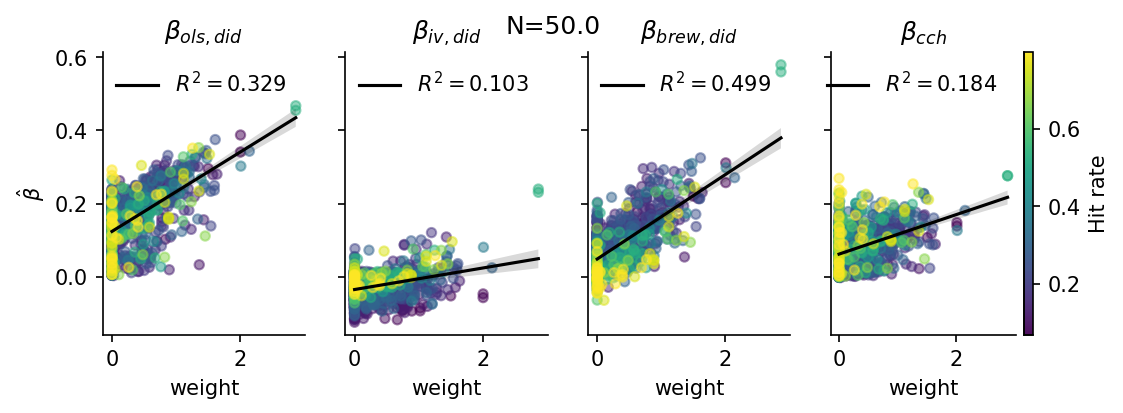

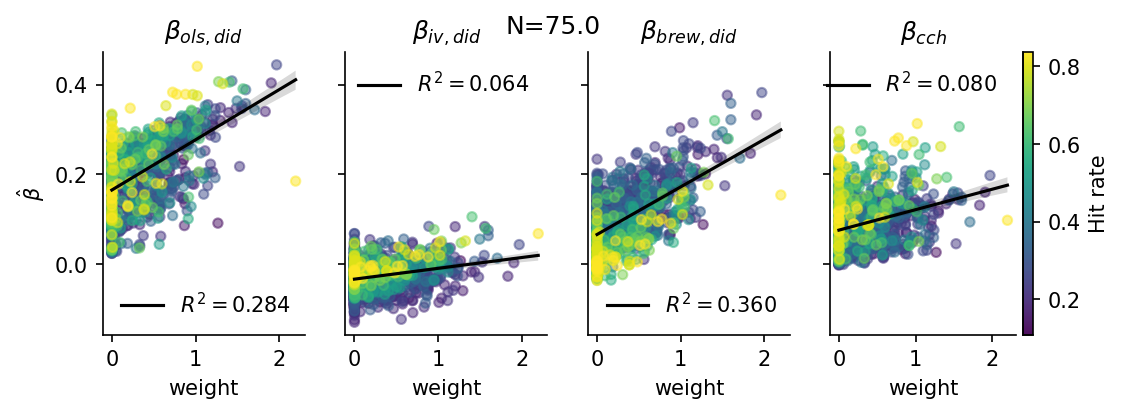

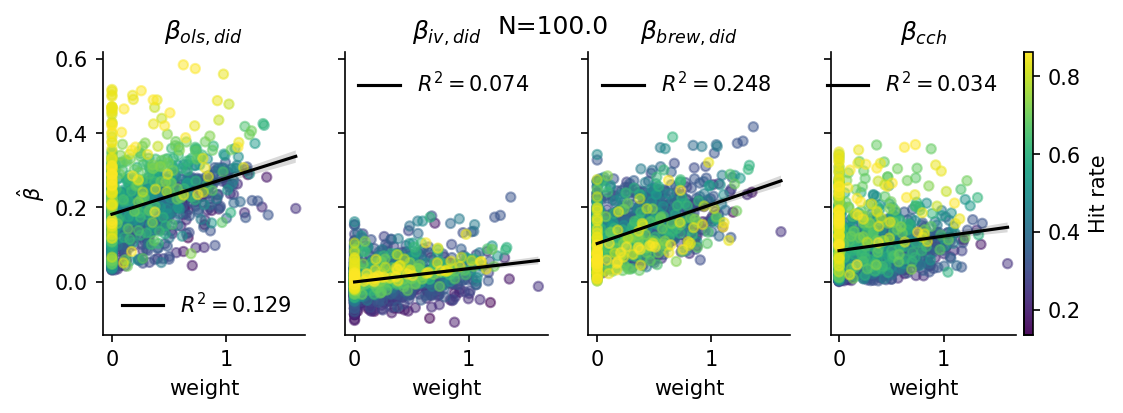

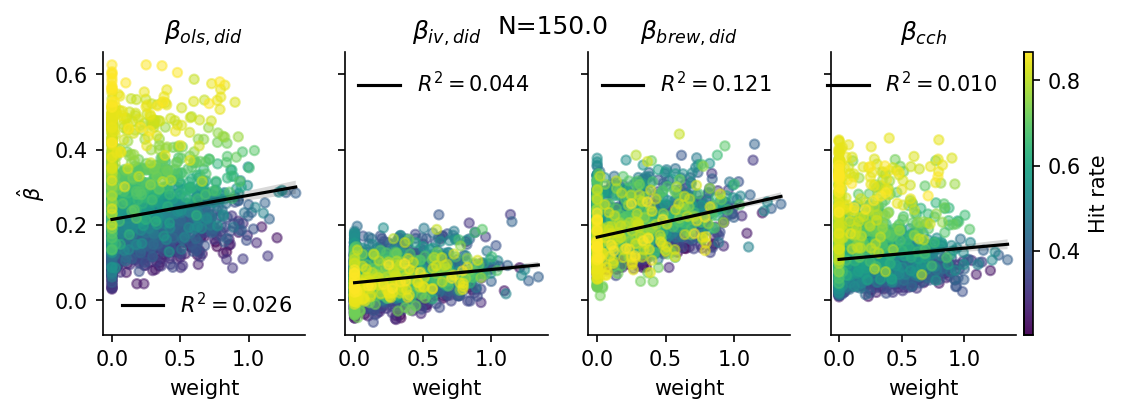

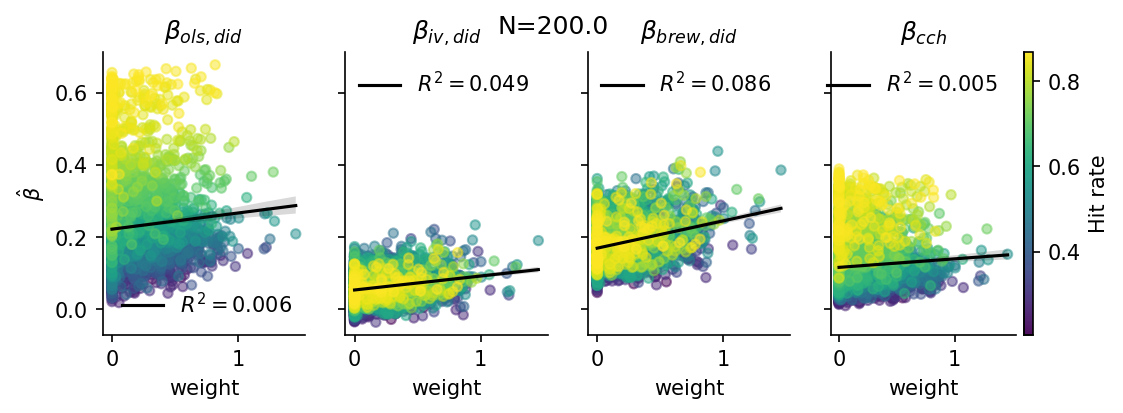

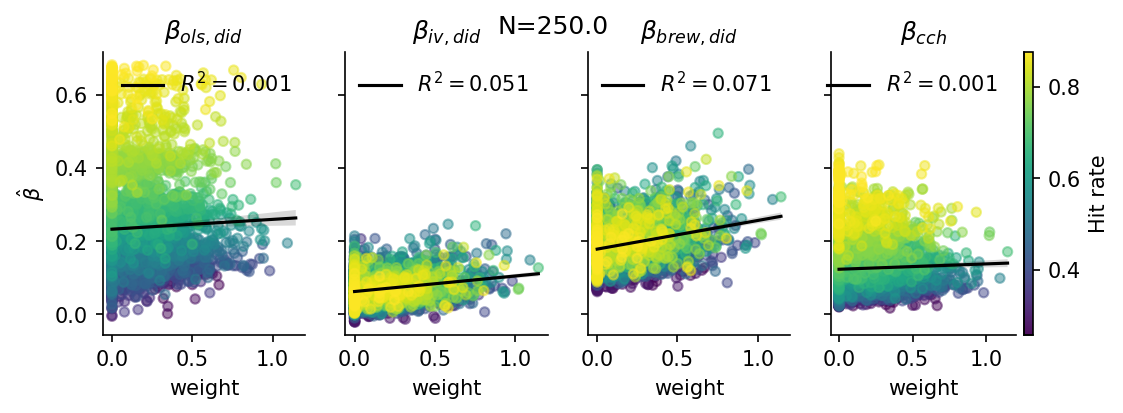

In [15]:
for i, (n_neurons, dff) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    df = samples[int(dff.index.values)]
    df['ww'] = df.hit_rate.round(3)
    subsample = df.groupby('ww').sample(25)
    plot_regression(
        subsample.query('weight>=0'), ['beta_ols_did','beta_iv_did', 'beta_brew_did', 'naive_cch'], 
        scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')
    plt.suptitle(f'N={n_neurons}')
    savefig(f'sweep_13_scatter_{n_neurons}')

# Classify

In [16]:
keys = ['beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did', 'naive_cch']

In [67]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'network_size': ser.n_neurons*2,
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

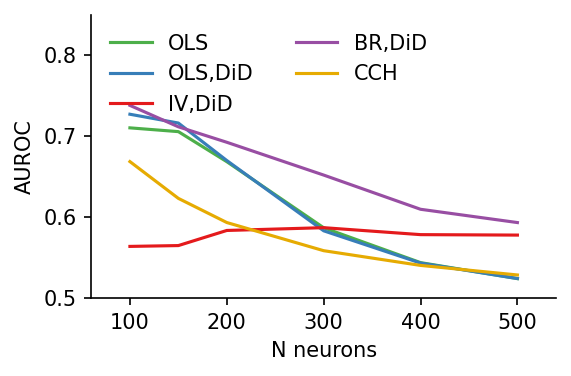

In [68]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="network_size", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('N neurons')
plt.ylim(0.5, 0.85)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_13_auroc_n_neurons')

# Convergence

In [19]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/960 [00:00<?, ?it/s]

In [20]:
error_convergence_trials = compute_error_convergence_trials(data_path, n_samples=100)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [42]:
errors['weight>=0'].loc[index]

path                   /home/users/bjornmik/datasets/sweep_13_ss6_np1...
const                                                                5.0
n_neurons                                                          250.0
n_neurons_ex                                                         NaN
n_neurons_in                                                         NaN
dt                                                                 0.001
ref_scale                                                           10.0
abs_ref_scale                                                        3.0
spike_scale                                                          5.0
abs_ref_strength                                                  -100.0
rel_ref_strength                                                   -30.0
stim_scale                                                           2.0
stim_strength                                                        6.0
stim_period                                        

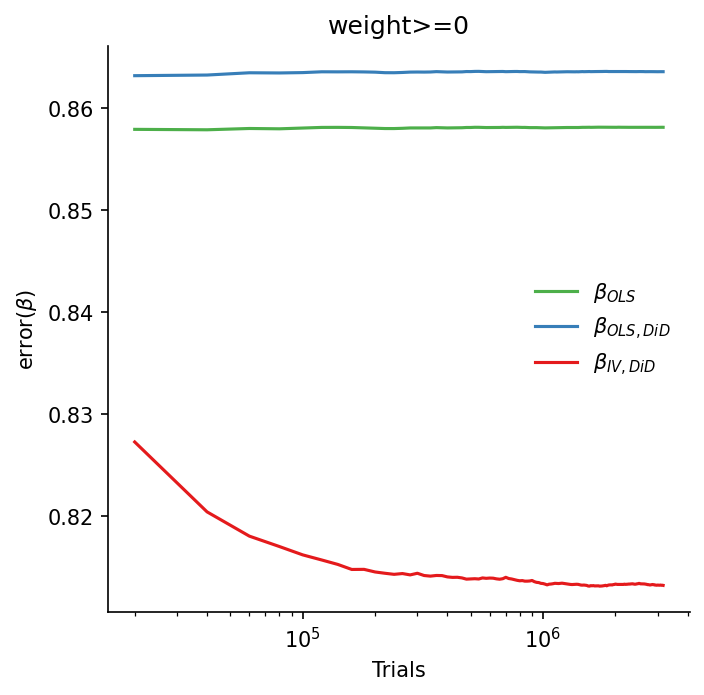

In [43]:
plot_error_convergence(error_convergence, index, ['beta_ols', 'beta_ols_did', 'beta_iv_did'])

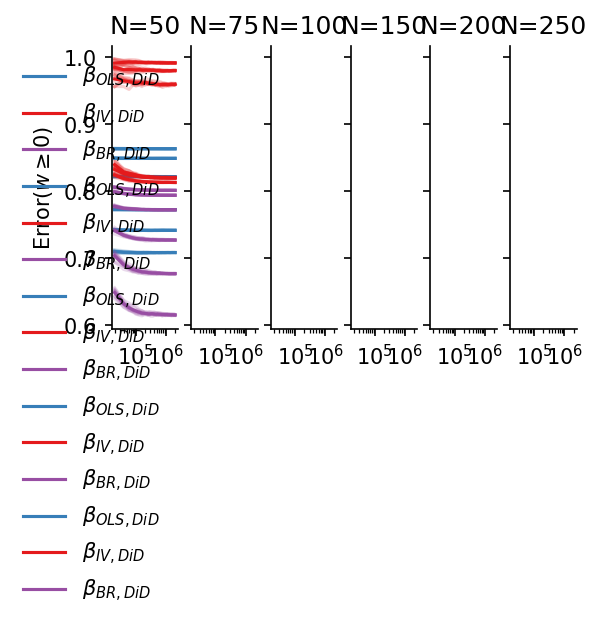

In [56]:
fig, axs = plt.subplots(1, 6, sharex=True, sharey='row')
for i, (n_neurons, df) in enumerate(errors['weight>=0'].groupby('n_neurons')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['beta_ols_did','beta_iv_did', 'beta_brew_did'], 
        axs=axs, legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[i].set_title(f'N={n_neurons:.0f}')

# Error difference

In [ ]:
error_trials = compute_error_trials(data_path, n_samples=10)

In [ ]:
errors = compute_error_confidence(errors, error_trials)

In [ ]:
plot_error_difference(errors, 'n_stim')

In [ ]:
def si(n):
    ne = 0.8*n
    se = 1 - 100 / n
    ni = n-ne
    return 1 - ne*(1-se)/ni

In [ ]:
n = np.arange(100, 600, 100)
plt.plot(n, si(n))

In [ ]:
1 - 100 / n * 0.8

In [ ]:
1 - 100 / n * 0.2